# COVID-19 | Week 2 : A Data Visualization Approach
<br>
<br>


![Markdown Logo is here.](https://media.defense.gov/2020/Mar/09/2002265190/780/780/0/200309-D-HN545-003.JPG)


<br>

### *Nicolas Hubert, Junior Data Scientist*

*03/29/2020*

<br> <font size="3"> 

***

*Please note that this report is only intended for data analysis and visualization purposes. The main goal is to show how several Python librairies can be leveraged for analysing real datasets. Please also note that the figures used in this notebook are not up-to-date. If you want to track COVID-19 related data in real time, you might be interested in <a href="http://www.cidrap.umn.edu/covid-19/maps-visuals" target="_blank">this link</a> that will provide you with various data visualization alternatives.*

***

This report is based on multiple datasets from different locations. Most of them were extracted from Kaggle, World Bank Data and GitHub repositories. A lot of data cleaning and preprocessing has been made, so you won't find them as is. Should you want access to all the datasets that have been used, feel free to contact me : nicolas.hubert@eleves.ec-nantes.fr.
I will then send you the relevant files in order to reproduce the outputs of this notebook.

All the code used to render the plots can be displayed by cliking on the following button :


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>''')

## Import

In [2]:
import os
from pathlib import Path
import json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz, process
from matplotlib.colors import Normalize
from matplotlib import cm
from itertools import product
import copy
import seaborn as sns
import colorcet as cc
from scipy.stats.kde import gaussian_kde
from bokeh.io import output_file, output_notebook, show
output_notebook()
from bokeh.models import ColumnDataSource, FixedTicker, PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.sampledata.perceptions import probly
# import branca
# import geopandas as gpd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap
import folium.plugins
import folium
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import time
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')

C:\Users\acer\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Loading BokehJS ...

## Global Analysis of COVID-19

In [3]:
df = pd.read_csv("global.csv")

In [4]:
print("Period ranging from ", df["Date"].min(), "to", df["Date"].max())
start_date = date(2020,1,22)
end_date = date(2020,3,26)
delta = end_date - start_date
print("Number of days for analysis : ", delta.days)
print("Number of countries : ", df["Country_Region"].nunique())
print("Records without an assigned country :", df["Country_Region"].isna().sum())
print("Records without an assigned province :", df["Province_State"].isna().sum())
print("Countries with assigned Province/State : ", df[df['Province_State'].isna()==False]['Country_Region'].nunique())
print("that are : ", df[df['Province_State'].isna()==False]['Country_Region'].unique())

Period ranging from  2020-01-22 to 2020-03-26
Number of days for analysis :  64
Number of countries :  173
Records without an assigned country : 0
Records without an assigned province : 10985
Countries with assigned Province/State :  8
that are :  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


In [5]:
confirmed_cases_date = df.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_date = df.groupby(['Date']).agg({'Fatalities':['sum']})
situation_date = confirmed_cases_date.join(fatalities_date)

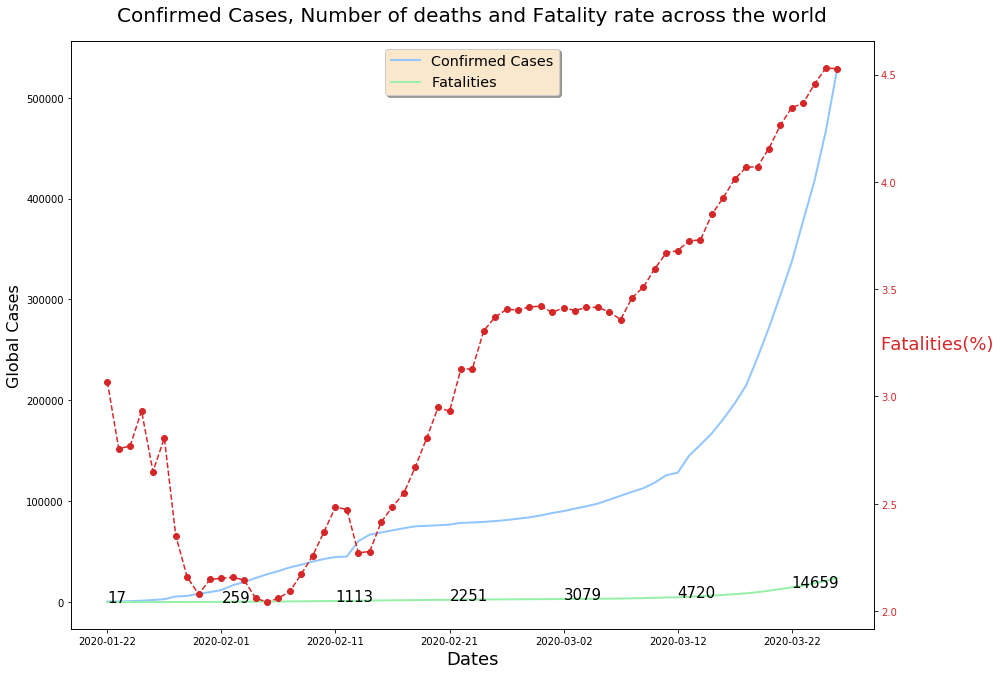

In [6]:
fatality_ratio = fatalities_date.values/confirmed_cases_date.values

with plt.style.context(style='seaborn-pastel'):
    fig, ax1 = plt.subplots(1, 1, figsize=(14,9))
    situation_date.plot(ax=ax1 ,lw=2);
    ax1.set_xlabel('Dates', size=18)
    ax1.set_ylabel('Global Cases', size = 16)
    ax1.tick_params(axis='y')
    for i in np.linspace(0,60,num=7):
        
        ax1.text(x=i, y=(fatalities_date.values[int(i)]), s=int(fatalities_date.values[int(i)]), size=15)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.plot((fatality_ratio)*100, color=color, marker='o', linestyle='dashed')
    ax2.set_ylabel('Fatalities(%)', color=color, size = 18, rotation= 0, position = (0,0.5), labelpad=40)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout() 
    plt.title('Confirmed Cases, Number of deaths and Fatality rate across the world', size=20, pad=20)
    legend = ax1.legend(['Confirmed Cases', 'Fatalities'], loc='upper center', shadow=True, fontsize='x-large')
    legend.get_frame().set_facecolor('#FBE8CC')
    plt.show()

<br> <font size="3"> Interestingly, the death rate dropped a little, then rocketted. As of late March, the death rate is around 4.5% globally, which is pretty high. As we will see later on, this rate is, in fact, very heterogenous. Some countries have an astonishing rate of roughly 10%, while others are more about 1-2%.

The exponential growth of the Confirmed Cases is clearly visible here.

In [7]:
complete_df = pd.read_csv("complete_df.csv")

complete_df["Active"] = complete_df["Confirmed"] - complete_df["Deaths"] - complete_df["Recovered"]

complete_df[['Province/State']] = complete_df[['Province/State']].fillna('')
complete_df[['Confirmed', 'Deaths', 'Recovered', 'Active']] = complete_df[['Confirmed', 'Deaths', 'Recovered', 'Active']].fillna(0)

global_time_series = complete_df.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active', 'Lat', 'Long'].sum().sort_values(by='Confirmed').reset_index()
global_time_series['%Fatality'] = round((global_time_series['Deaths']/global_time_series['Confirmed'])*100,2)

In [8]:
tmp = global_time_series[global_time_series['Confirmed']==max(global_time_series['Confirmed'])].reset_index(drop=True)
tree_map = tmp.melt(id_vars="Date", value_vars=['Deaths', 'Recovered', 'Active'])
fig = px.treemap(tree_map, path=["variable"], values="value", height=600, width=900, 
                 title='Overview of the current health crisis (03/26/2020)')
fig.data[0].textinfo = 'label+text+value'
fig.show()

In [9]:
current_global_situation = complete_df[complete_df["Date"] == '3/26/20']
current_global_situation = current_global_situation.groupby(['Country/Region', 'Lat', 'Long']).sum().reset_index()

In [10]:
# df = px.data.gapminder() # utility dataset for getting iso_alpha (visualisation purpose)

In [11]:
# df.rename(columns={"country": "Country/Region"}, inplace=True)
# df.drop(columns=['continent', 'year', 'lifeExp', 'pop', 'gdpPercap', 'iso_num'], inplace=True)
# df.drop_duplicates(keep='first', inplace=True)

In [12]:
# current_global_situation.loc[current_global_situation['Country/Region'] == "US", 'Country/Region'] = 'United States'
# current_global_situation.loc[current_global_situation['Country/Region'] == "South Korea", 'Country/Region'] = 'Korea, Rep.'
# current_global_situation.loc[current_global_situation['Country/Region'] == "'Czechia'", 'Country/Region'] = 'Czech Republic'
# We limit ourselves to the most concerned countries
# Some won't display because there is no iso_alpha linked to these particular countries

In [13]:
# current_global_situation = pd.merge(current_global_situation, df, on='Country/Region', how='left')

In [14]:
fig = px.scatter_geo(current_global_situation, lat='Lat', lon='Long', color="Confirmed",
                     hover_name="Country/Region", size="Confirmed",
                     projection="natural earth", size_max=60, title='COVID-19 Current situation across the world')
fig.show()

In [15]:
fig = px.scatter_geo(complete_df, lat='Lat', lon='Long', color="Confirmed",
                     hover_name="Country/Region", size="Confirmed",
                     projection="natural earth", size_max=60, animation_frame="Date",
                     title='COVID-19 Spread through time')
fig.show()

In [16]:
countries = current_global_situation.groupby("Country/Region").sum().sort_values("Confirmed", ascending=False).reset_index()["Country/Region"][:20].values
active = current_global_situation.groupby("Country/Region").sum().sort_values("Confirmed", ascending=False).reset_index()["Active"][:20].values
deaths = current_global_situation.groupby("Country/Region").sum().sort_values("Confirmed", ascending=False).reset_index()["Deaths"][:20].values
recovered = current_global_situation.groupby("Country/Region").sum().sort_values("Confirmed", ascending=False).reset_index()["Recovered"][:20].values

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=active,
    y=countries,
    marker=dict(color="gold", size=12),
    mode="markers",
    name="Active",
))

fig.add_trace(go.Scatter(
    x=deaths,
    y=countries,
    marker=dict(color="crimson", size=12),
    mode="markers",
    name="Deaths",
))

fig.add_trace(go.Scatter(
    x=recovered,
    y=countries,
    marker=dict(color="green", size=12),
    mode="markers",
    name="Recovered",
))

fig.update_layout(title="Top 20 Countries Comparison",
                  xaxis_title="Total number of cases",
                  yaxis_title="Countries", width=960, height=800)

fig.show()

In [17]:
tmp = current_global_situation
tmp["world"] = "world" # in order to have a single root node
fig = px.treemap(tmp, path=['world', 'Country/Region'], values='Confirmed',
                  color='Confirmed', hover_data=['Country/Region'],
                  color_continuous_scale='RdBu', width=960, height=800, title='COVID-19 : Grasp some sense of proportions')
fig.show()

In [18]:
EU_countries = ['Switzerland','Italy','Spain','France','Germany']
complete_df['Date'] = pd.to_datetime(complete_df['Date'])
tt = complete_df[complete_df["Country/Region"].isin(EU_countries)].groupby(by=["Country/Region","Date"]).sum().reset_index()

In [19]:
date_series = pd.date_range(start='2020-01-22', end='2020-03-26')

p = figure(plot_width = 920, plot_height = 600, title="Comparison of COVID-19 Spread across major EU countries", 
           x_axis_type='datetime', y_range=(100, 90000),
           x_axis_label='Dates', y_axis_label='Confirmed Cases',
           background_fill_color="#fafafa")
    
p.line(date_series, tt[tt["Country/Region"]=="Spain"][["Confirmed"]].values.tolist(),
       legend_label="Spain",
       line_color="tomato", line_dash="dashed", line_width=3)


p.line(date_series, tt[tt["Country/Region"]=="Germany"][["Confirmed"]].values.tolist(),
       legend_label="Germany",
       line_color="purple", line_dash="dashed", line_width=3)


p.line(date_series, tt[tt["Country/Region"]=="Italy"][["Confirmed"]].values.tolist(),
       legend_label="Italy",
       line_color="green", line_dash="dashed", line_width=3)


p.line(date_series, tt[tt["Country/Region"]=="Switzerland"][["Confirmed"]].values.tolist(),
       legend_label="Switzerland",
       line_color="black", line_dash="dashed", line_width=3)


p.line(date_series, tt[tt["Country/Region"]=="France"][["Confirmed"]].values.tolist(),
       legend_label="France",
       line_color="blue", line_dash="dashed", line_width=3)

p.title.text_font_size = '18pt'

p.legend.location = "top_left"

show(p)

<br> <font size="3"> As expected, we see there is a delay in the COVID-19 spread across EU countries : Italy were obviously the first one to be affected. France, Germany and Spain's health crises took place about ten days later and their respective spread growth are similar (although France growth rate is less steep). Switzerland coronavirus spread a few days later and the growth seems less worrying. **But** Swiss population is only 12.8% that of France. In fact, the growth is even more acute in Switzerland than in any other EU country.

In [20]:
world = pd.read_csv("w_bank.csv")
world = world.drop(columns= ['Year', 'Year Code', 'Series Code'])

In [21]:
cols = [col for col in world.columns if col in ['Series Name', 'Italy [ITA]', 'United Kingdom [GBR]', 'Canada [CAN]',
                                                'China [CHN]', 'France [FRA]', 'Germany [DEU]', 'Sweden [SWE]',
                                                'Spain [ESP]', 'Switzerland [CHE]', 'United States [USA]']]

world = world[cols]
world.set_index('Series Name', inplace=True)

In [22]:
world.rename(columns={"Italy [ITA]": "Italy", "United Kingdom [GBR]": "United Kingdom", "Canada [CAN]": "Canada",
                     "China [CHN]": "China", "France [FRA]": "France", "Germany [DEU]": "Germany",
                     "Sweden [SWE]": "Sweden", "Spain [ESP]": "Spain", "Switzerland [CHE]": "Switzerland",
                     "United States [USA]" :"US"}, inplace=True)
world = world.T
world.dropna(axis='columns', inplace=True)
world = world.sort_index()

In [23]:
cols = [col for col in world.index.tolist()]
smoke = pd.read_csv("smoke.csv")
smoke = smoke.sort_values(by="name")
smoke.iloc[-6,0] = 'US'
smoke = smoke[smoke.name.isin(cols)]

In [24]:
overweight = pd.read_csv("overweight.csv", index_col=0)
overweight = overweight.sort_index()
overweight = overweight.rename(index={'United States of America': 'US', 
                                      'United Kingdom of Great Britain and Northern Ireland' : 'United Kingdom'})
overweight = overweight[overweight.index.isin(cols)]
overweight["2016"] = overweight["2016"].str.slice(stop=4)
overweight["2016"] = overweight["2016"].astype(float)

In [25]:
tmp = complete_df[complete_df["Date"]=="2020-03-26"]
tmp = tmp[tmp["Country/Region"].isin(world.index)]
tmp = tmp.groupby(by="Country/Region").sum().sort_index()
world['Confirmed'] = tmp['Confirmed']
world['Deaths'] = tmp['Deaths']
world['Active'] = tmp['Active']
world['Fatality (%)'] = (world['Deaths']/world['Confirmed'])*100
world = world.reset_index()
cols = [x for x in world.columns if x != 'index']
for col in cols :
    world[col] = pd.to_numeric(world[col],errors='coerce')
world.dropna(axis='columns', inplace=True)
world.rename(columns={'index':'Country'}, inplace=True)
b, c = world.iloc[-1].copy(), world.iloc[-2].copy()
world.iloc[-1], world.iloc[-2] = c,b
world['Smoking Rate (%) (Adult 18+)'] = smoke['totalSmokingRate'].values
world['Overweight Prevalence (%) (Adult 18+)'] = overweight['2016'].values

<font size="3"> In the following five plots, we aim at showing whether there is some sort of relation between the national death rates and some factors, and the number of confirmed cases per country and some other factors, respectively.

There is no point in being accurate here. It is enough to grasp some intuitive knowledge about the relationships between variables.

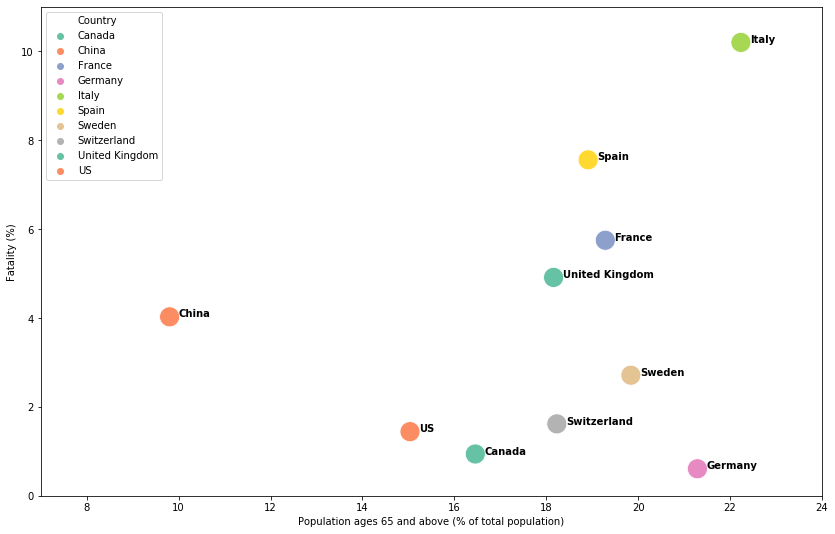

In [26]:
fig_dims = (14, 9)
fig, ax = plt.subplots(figsize=fig_dims)

p=sns.scatterplot(y='Fatality (%)', x='Population ages 65 and above (% of total population)', hue='Country',
                s=400, hue_norm=(0, 7), palette="Set2", data=world, ax=ax);

# add annotations one by one with a loop
for line in range(0,world.shape[0]):
     p.text(world['Population ages 65 and above (% of total population)'][line]+0.2, world['Fatality (%)'][line], 
             world['Country'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
        
# control x and y limits
plt.ylim(0, 11)
plt.xlim(7, 24)
plt.show()

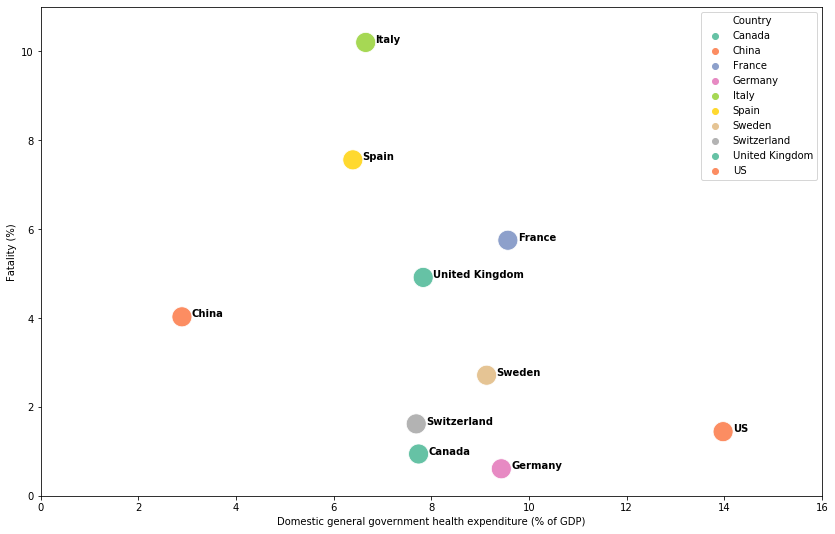

In [27]:
fig_dims = (14, 9)
fig, ax = plt.subplots(figsize=fig_dims)

p=sns.scatterplot(y='Fatality (%)', x='Domestic general government health expenditure (% of GDP)', hue='Country',
                s=400, hue_norm=(0, 7), palette="Set2", data=world, ax=ax);

# add annotations one by one with a loop
for line in range(0,world.shape[0]):
     p.text(world['Domestic general government health expenditure (% of GDP)'][line]+0.2, world['Fatality (%)'][line], 
             world['Country'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
        
# control x and y limits
plt.ylim(0, 11)
plt.xlim(0, 16)
plt.show()

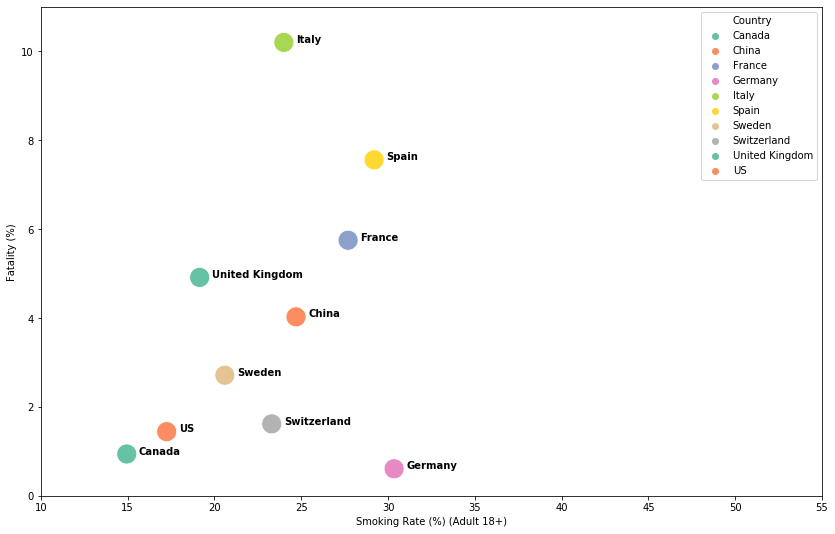

In [28]:
fig_dims = (14, 9)
fig, ax = plt.subplots(figsize=fig_dims)

p=sns.scatterplot(y='Fatality (%)', x='Smoking Rate (%) (Adult 18+)', hue='Country',
                s=400, hue_norm=(0, 7), palette="Set2", data=world, ax=ax);

# add annotations one by one with a loop
for line in range(0,world.shape[0]):
     p.text(world['Smoking Rate (%) (Adult 18+)'][line]+0.7, world['Fatality (%)'][line], 
             world['Country'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
        
# control x and y limits
plt.ylim(0, 11)
plt.xlim(10, 55)
plt.show()

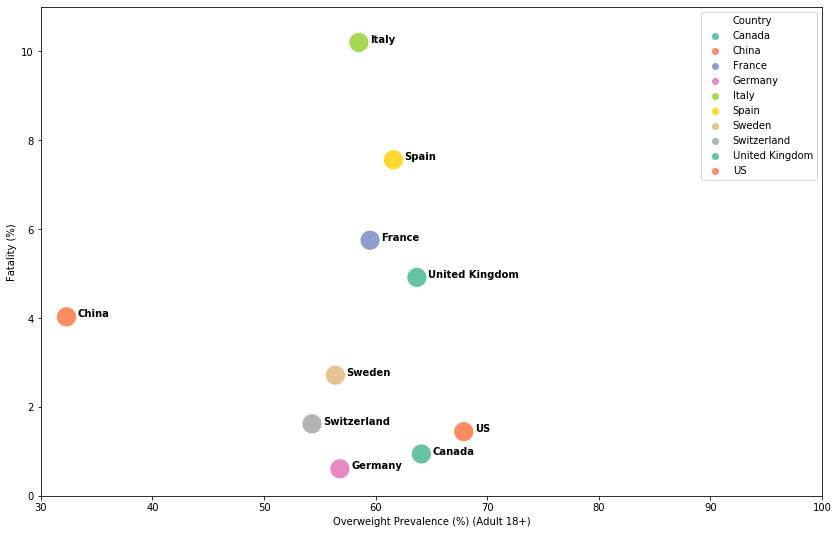

In [29]:
fig_dims = (14, 9)
fig, ax = plt.subplots(figsize=fig_dims)

p=sns.scatterplot(y='Fatality (%)', x='Overweight Prevalence (%) (Adult 18+)', hue='Country',
                s=400, hue_norm=(0, 7), palette="Set2", data=world, ax=ax);

# add annotations one by one with a loop
for line in range(0,world.shape[0]):
     p.text(world['Overweight Prevalence (%) (Adult 18+)'][line]+1, world['Fatality (%)'][line], 
             world['Country'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
        
# control x and y limits
plt.ylim(0, 11)
plt.xlim(30, 100)
plt.show()

In [30]:
un_data = pd.read_csv('un_data.csv')
keep_countries = ['Italy', 'United Kingdom', 'Canada','China', 'France', 'Germany', 'Sweden', 'Spain', 
                  'Switzerland', 'United States of America']
un_data = un_data[un_data["country"].isin(keep_countries)]
un_data.sort_values(by="country")
un_data = un_data[['Population density (per km2, 2017)','Urban population (% of total population)',
                   'Population in thousands (2017)']]
for col in un_data.columns :
    un_data[col] = pd.to_numeric(un_data[col],errors='coerce')
world['Pop density/km²'] = un_data['Population density (per km2, 2017)'].values
# world['Urban Pop (%)'] = un_data['Urban population (% of total population)'].values
world['Pop (in thousands)'] = un_data['Population in thousands (2017)'].values
world['Confirmed (in % of Total Pop)'] = (world['Confirmed'] / (world['Pop (in thousands)']*1000))*100

In [31]:
keep_countries = ['Italy', 'United Kingdom', 'Canada','China', 'France', 'Germany', 'Sweden', 'Spain', 
                  'Switzerland', 'US']
tmp = complete_df[complete_df["Country/Region"].isin(keep_countries)].groupby(by=["Country/Region", "Date"]).sum()
tmp = tmp.sort_values(by=["Country/Region", "Date"]).reset_index()
tmp.iloc[-1,2] # ok
tmp.drop(tmp[tmp["Confirmed"] < 1].index, inplace=True)
tmp["Spread Rate"] = tmp["Confirmed"].pct_change()
tmp = tmp.groupby(["Country/Region"])[["Spread Rate"]].mean()
tmp.iloc[-1,0] = 0.203527
tmp.iloc[-2,0] = 0.174214
world["Average Daily Spread Rate (%)"] = (tmp.values)*100

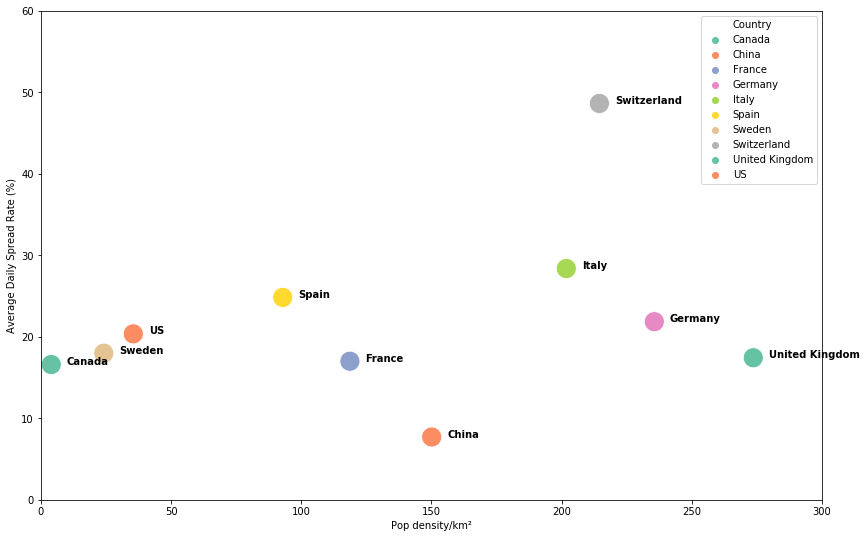

In [32]:
fig_dims = (14, 9)
fig, ax = plt.subplots(figsize=fig_dims)

p=sns.scatterplot(y="Average Daily Spread Rate (%)", x='Pop density/km²', hue='Country',
                s=400, hue_norm=(0, 7), palette="Set2", data=world, ax=ax);

# add annotations one by one with a loop
for line in range(0,world.shape[0]):
     p.text(world['Pop density/km²'][line]+6, world["Average Daily Spread Rate (%)"][line], 
             world['Country'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
        
# control x and y limits
plt.ylim(0, 60)
plt.xlim(0, 300)
plt.show()

<br> <font size="3"> In the correlation frameworks below, the biggest drivers of the output (either "Confirmed" or "Fatality Rate") are the input variables (i.e factors) which have the greatest **absolute** correlation value.

Correlation lies in the range [-1,1], and:

* Negative correlation (correlation < 0) implies that the input and output move in opposite directions - i.e. as the input increases, the output decreases (and vice versa).
* Nil correlation (correlation == 0) implies that the two variables are completely unrelated.
* Positive correlation (correlation > 0) implies that the input and output move in the same direction - i.e. as the input increases, the output increases (and vice versa). </font>

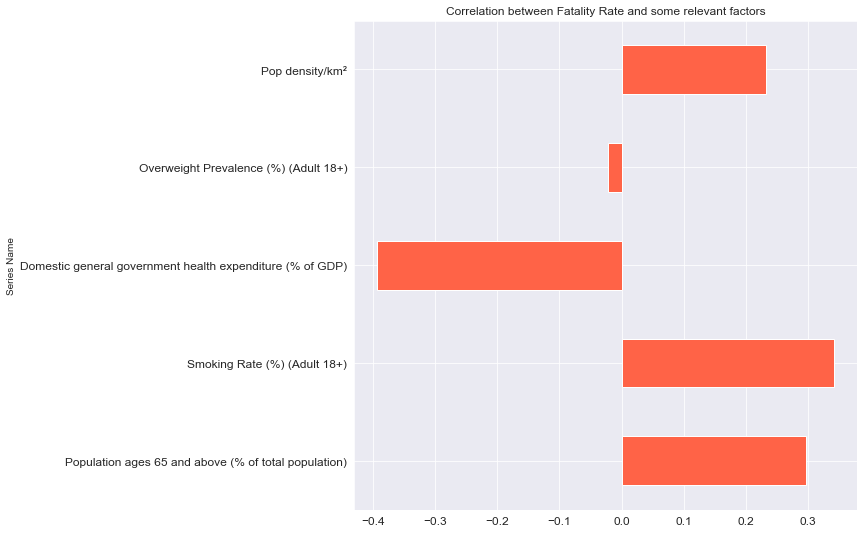

In [33]:
for_corr = world[['Country', 'Population ages 65 and above (% of total population)', 'Smoking Rate (%) (Adult 18+)',
                  'Domestic general government health expenditure (% of GDP)', 
                  'Overweight Prevalence (%) (Adult 18+)',
                  'Pop density/km²']]

for_corr.reset_index(drop=True, inplace=True)
for_corr.index.name = None

sns.set_style("dark")

for_corr.corrwith(world['Fatality (%)']).plot(kind='barh',figsize=[9,9], fontsize=12,
                                              title='Correlation between Fatality Rate and some relevant factors',
                                              legend=False, grid=True, color='tomato');

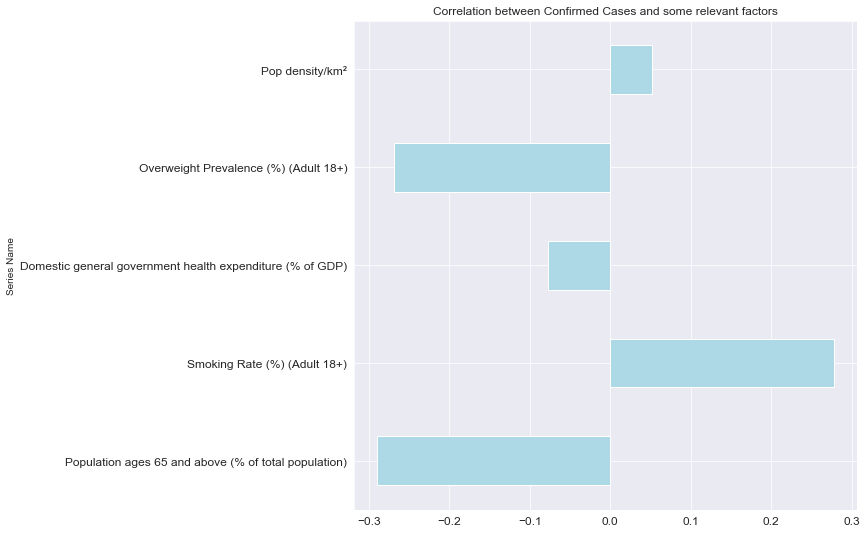

In [34]:
for_corr = world[['Country', 'Population ages 65 and above (% of total population)', 'Smoking Rate (%) (Adult 18+)',
                  'Domestic general government health expenditure (% of GDP)', 
                  'Overweight Prevalence (%) (Adult 18+)',
                  'Pop density/km²']]
for_corr.corrwith(world['Confirmed']).plot(kind='barh',figsize=[9,9], fontsize=12,
                                           title='Correlation between Confirmed Cases and some relevant factors',
                                           legend=False, grid=True, color='lightblue');

<br> <font size="3"> It is really weird that Overweight prevalence shares such a correlation with Confirmed Cases, while it seems to matter less when it comes to Fatality Rate. Plus, one could have intuitively thought that population density per km² would share a greater correlation, too.
In overall, all the above studied correlations are pretty weak.

## COVID-19 : One country, one outbreak

### <font size="5"> Italy </font> | <font size="3"> Situation as of 03/27/2020 </font>

In [35]:
# ita_df = pd.read_csv('ita_latest.csv')
# ita_df = ita_df[["data", "codice_regione", "denominazione_regione", "lat", "long", "totale_casi", "deceduti"]]
# ita_df.to_csv("ita_df_clean.csv")

In [36]:
ita_df = pd.read_csv("ita_df_clean.csv")
ita_df = ita_df.applymap(str)

In [37]:
ITA_LAT = 41.902782
ITA_LONG = 12.496366
file_path = os.path.join(os.getcwd(),'ita.json') 
file_geojson = json.load(open(file_path))

In [38]:
locations = ita_df[['lat', 'long']]
locationlist = locations.values.tolist()

In [39]:
# t = folium.Map(location=[ITA_LAT, ITA_LONG], zoom_start=7)

# marker_cluster = folium.plugins.MarkerCluster().add_to(t)

# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point], popup=ita_df['denominazione_regione'][point]
#                   +' '+'Confirmed:'+ita_df['totale_casi'][point]
#                   +' '+'Deaths :'+ita_df['deceduti'][point], 
#                   icon=folium.Icon(color=ita_df["totale_casi"][point], 
#                                     icon_color='white', icon='fa-medkit', angle=0, prefix='fa')).add_to(marker_cluster)
# # https://fontawesome.com/v4.7.0/icons/
# t

In [40]:
# Make an empty map
ita = folium.Map(location=[ITA_LAT, ITA_LONG], zoom_start=6)

 
# Add marker one by one on the map
for point in range(0, len(locationlist)):
    folium.Circle(
      location=locationlist[point],
      popup=ita_df['denominazione_regione'][point]
                  +' '+'Confirmed:'+ita_df['totale_casi'][point]
                  +' '+'Deaths :'+ita_df['deceduti'][point],
      radius=(int(ita_df.iloc[point]['totale_casi'])+7000)*1.8,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(ita)
ita

### <font size="5"> France </font> | <font size="3"> Situation as of 03/27/2020 </font>

In [41]:
# fr_df = pd.read_csv('fr_latest.csv')
# fr_df = fr_df[fr_df["Date"]=="2020/03/25"].T
# fr_df.drop(fr_df.index[0],inplace=True)
# fr_df.rename(columns={"19": "Confirmed Cases"}, inplace=True)
# ind = fr_df.index
# fr_df = pd.DataFrame(data=fr_df.values, columns=["Confirmed Cases"], index=ind)
# fr_df = fr_df.iloc[:13,:]
# tmp = pd.read_csv('worldcities.csv')
# tmp = tmp[tmp.country=='France']
# tmp = tmp[tmp.capital.isin(['admin', 'primary'])]
# tmp.iloc[0,7] = "Ile-de-France"
# tmp = tmp.sort_values("admin_name")
# fr_df["lat"] = tmp.lat.values
# fr_df["long"] = tmp.lng.values
# fr_df.to_csv("fr_df_clean.csv")

In [42]:
fr_df = pd.read_csv("fr_df_clean.csv", index_col=0)
fr_df = fr_df.applymap(str)

In [43]:
FR_LAT = 46.7
FR_LONG = 3.5
file_path = os.path.join(os.getcwd(),'fr.json') 
file_geojson = json.load(open(file_path))
locations = fr_df[['lat', 'long']]
locationlist = locations.values.tolist()

In [44]:
# Make an empty map
fr = folium.Map(location=[FR_LAT, FR_LONG], zoom_start=6)

 
# Add marker one by one on the map
for point in range(0, len(locationlist)):
    folium.Circle(
      location=locationlist[point],
      popup=fr_df.index[point]
                  +' '+'Confirmed:'+fr_df['Confirmed Cases'][point],
      radius=(int(fr_df.iloc[point]['Confirmed Cases'])+7000)*4,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(fr)
fr

### <font size="5"> USA </font> | <font size="3"> Situation as of 03/25/2020 </font>

<br> <font size="3"> The USA is our last country to study, firstly because the outbreak is really located in the NY area, and secondly because the Plotly library comes with a pretty neat built-in function for plotting on the US map.

In [45]:
us_df = pd.read_csv('us_statesNT.csv')
us_current = us_df[us_df["date"]=='2020-03-25']

In [46]:
us_locations = pd.read_csv("us_correspondance.csv")
us_locations.rename(columns={"stname" : "state"}, inplace=True)
us_current = pd.merge(us_current, us_locations[["state"," stusps"]], on="state", how="left")
us_current.rename(columns={" stusps" : "abbrev"}, inplace=True)

In [47]:
us_current[us_current["abbrev"].isna()]
us_current.drop(us_current.index[[11,40,48]],inplace=True)

In [48]:
latlong = pd.read_csv("statelatlong.csv")
latlong.rename(columns={"State" : "abbrev", "City" : "state"}, inplace=True)
us_current = pd.merge(us_current, latlong[["state","Latitude", "Longitude"]], on="state", how="left")

In [49]:
text = us_current['state'] + us_current['abbrev'] + '<br>' + 'Confirmed Cases : ' + us_current['cases'].astype(str)
data = [dict(type='scattergeo',locationmode = 'USA-states',
             lat = us_current.Latitude, lon = us_current.Longitude, 
             text = text, hoverinfo = 'text',
             marker = dict(size = (us_current.cases + 100) ** 0.46,
            opacity = 0.8, autocolorscale=True,colorscale = 'Viridis',
            color = us_current.cases, colorbar = dict(title='Total Confirmed Cases per State')))]


layout = dict(title='U.S Map of COVID-19 Confirmed Cases',
              geo = dict(scope='usa',projection = dict(type ='albers usa'),showland = True,
                    landcolor="rgb(250,250,250)",subunitcolor = "rgb(217,217,217)",
                     countrycolor = "rgb(217,217,217)",countrywidth=0.5, subunitwidth=0.5))

plotly.offline.iplot({
    "data": data,
    "layout": layout
})